In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize']=(12,12)
mpl.rcParams['axes.grid']=False

import numpy as np
import PIL.Image
import time
import functools


In [3]:
def tentoimg(tensor):
    tensor =tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
def loadimg(pathimg):
    maxdim=512
    img=tf.io.read_file(pathimg)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    longdim=max(shape)
    scale=(maxdim/longdim)
    
    newshape=tf.cast(shape*scale,tf.int32)
    
    img=tf.image.resize(img,newshape)
    img=img[tf.newaxis,:]
    return img

In [5]:
def imshow(image,title=None):
    if len(image.shape)>3:
        image=tf.squeeze(image,axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

In [7]:
contentpath=tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('aaa.jpg','https://mblogthumb-phinf.pstatic.net/20150819_100/iamundine_1439970779216WcILD_JPEG/%BA%B0%C0%CC_%BA%FB%B3%AA%B4%C2_%B9%E3.jpg?type=w2')
contentimage=loadimg(contentpath)
styleimage=loadimg(style_path)

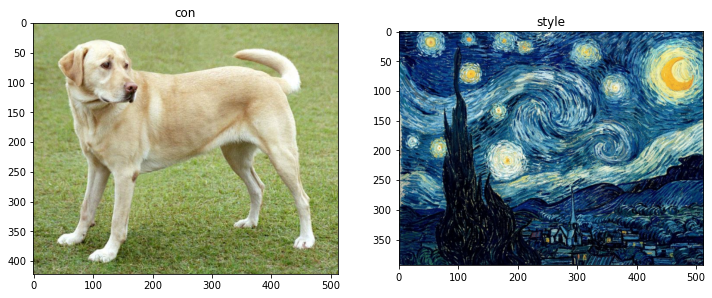

In [8]:
plt.subplot(1,2,1)
imshow(contentimage,'con')
plt.subplot(1,2,2)
imshow(styleimage,'style')

In [9]:
import tensorflow_hub as hub

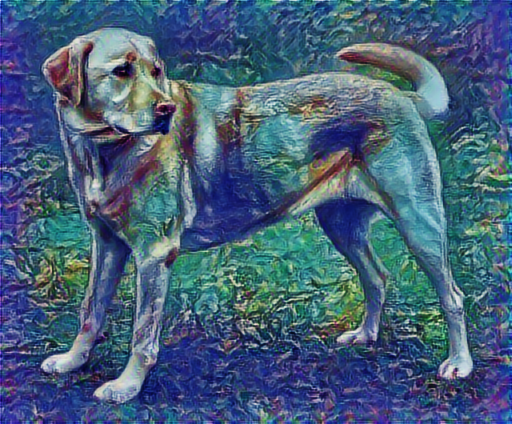

In [10]:
hubmodule=hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
styleizeimage=hubmodule(tf.constant(contentimage),tf.constant(styleimage))[0]
tentoimg(styleizeimage)

In [11]:
x=tf.keras.applications.vgg19.preprocess_input(contentimage*255)
x=tf.image.resize(x,(224,224))
vgg=tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prepro=vgg(x)
prepro.shape

574717952/574710816 [==============================] - 60s 0us/step


TensorShape([1, 1000])

In [13]:
pretop5=tf.keras.applications.vgg19.decode_predictions(prepro.numpy())[0]
pretop5

[('n02099712', 'Labrador_retriever', 0.49317107),
 ('n02099601', 'golden_retriever', 0.23665293),
 ('n02104029', 'kuvasz', 0.03635751),
 ('n02099849', 'Chesapeake_Bay_retriever', 0.024182767),
 ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646102)]

In [14]:
vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80142336/80134624 [==============================] - 8s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [15]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [17]:
def vgglayer(layername):
    vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    
    outputs=[vgg.get_layer(name).output for name in layername]
    
    model=tf.keras.Model([vgg.input],outputs)
    return model

In [20]:
style_extractor = vgglayer(style_layers)
style_outputs = style_extractor(styleimage*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 394, 512, 64)
  최솟값:  0.0
  최댓값:  805.02264
  평균:  27.390577

block2_conv1
  크기:  (1, 197, 256, 128)
  최솟값:  0.0
  최댓값:  3401.0483
  평균:  175.28584

block3_conv1
  크기:  (1, 98, 128, 256)
  최솟값:  0.0
  최댓값:  8667.521
  평균:  168.29263

block4_conv1
  크기:  (1, 49, 64, 512)
  최솟값:  0.0
  최댓값:  19387.867
  평균:  625.0499

block5_conv1
  크기:  (1, 24, 32, 512)
  최솟값:  0.0
  최댓값:  4897.1104
  평균:  51.84837



In [21]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [25]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self,style_layers,content_layers ):
        super(StyleContentModel,self).__init__()
        self.vgg=vgglayer(style_layers+content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False
    def call(self,inputs):
        inputs=inputs*255.0
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)
        style_outputs,content_outputs=(outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs=[gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict={content_name:value
                     for content_name,value
                     in zip(self.content_layers,content_outputs)}
        style_dict={style_name:value
                     for style_name,value
                     in zip(self.style_layers,style_outputs)}
        
        return {'content':content_dict,'style':style_dict}

In [26]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(contentimage))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0055228
    최댓값:  28014.557
    평균:  263.79022

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  61479.49
    평균:  9100.949

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  545623.44
    평균:  7660.976

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  4320501.5
    평균:  134288.84

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  110005.36
    평균:  1487.0378

콘텐츠:
   block5_conv2
    크기:  (1, 26, 32, 512)
    최솟값:  0.0
    최댓값:  2410.8796
    평균:  13.764149


In [28]:
style_targets = extractor(styleimage)['style']
content_targets = extractor(contentimage)['content']

In [29]:
image = tf.Variable(contentimage)

In [30]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [31]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [32]:
style_weight=1e-2
content_weight=1e4

In [33]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

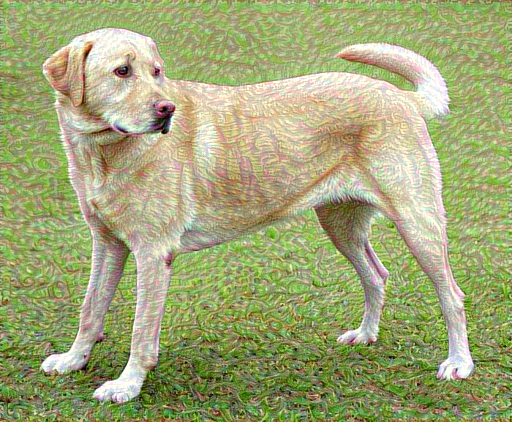

In [41]:
train_step(image)
tentoimg(image)

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

........